In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import random 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
import datetime 
import os.path  
import sys  

import backtrader as bt

In [4]:
df = pd.read_csv("./BTCUSDT20162018.csv", sep=',')

In [5]:
df.head()

,Open_time,Open,High,Low,Close,Volume
0,8/17/17 11:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,8/17/17 11:15,4261.48,4270.41,4261.32,4261.45,9.119865
2,8/17/17 11:30,4280.00,4310.07,4267.99,4310.07,21.923552
3,8/17/17 11:45,4310.07,4313.62,4291.37,4308.83,13.948531
4,8/17/17 12:00,4308.83,4328.69,4304.31,4304.31,5.101153


In [6]:
df.dtypes

Open_time     object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object

In [53]:
# Create a Stratey
import random
p = .5
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.buy_num = 0

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        try:
            self.log('Close, %.2f' % self.dataclose[0])

            # Check if an order is pending ... if yes, we cannot send a 2nd one
            if self.order:
                return
            bool_val = random.uniform(0, 1) < p
            buy_sig = bool_val * (self.dataclose[0]<self.dataclose[30])
            sell_sig = (-(-1)**bool_val) * (-(-1)**(self.dataclose[0]>self.dataclose[30]))
            print('-1^: ', -(-1)**(self.dataclose[0]>self.dataclose[30]))
            
            if self.dataclose[0]<self.dataclose[30]:
                if bool_val:
                    
                    if not self.position:

                        # Not yet ... we MIGHT BUY if ...

                        # BUY, BUY, BUY!!! (with all possible default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()
                        self.buy_num += 1

                else:
                    if not self.position:

                        # Not yet ... we MIGHT BUY if ...
                        return

                    else:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('SELL CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order

                        self.order = self.sell(size = self.buy_num)
                        self.buy_num = 0
            else:
                if bool_val:
                    if not self.position:
                        return
                    else:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('SELL CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order

                        self.order = self.sell(size = self.buy_num)
                        self.buy_num = 0
                else:
                    if not self.position:
                        # BUY, BUY, BUY!!! (with all possible default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()
                        self.buy_num += 1
                    else:
                        return
        except IndexError:
            print('self.buy_num: ', self.buy_num)
            if (self.buy_num >0):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell(size = self.buy_num)
            return




if __name__ == '__main__':
    # Create a cerebro entity
    buy = 0
    sell = 0
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.GenericCSVData(
        dataname='./BTCUSDT20162018.csv',

        fromdate=datetime.datetime(2017, 8, 17,11,0),
        todate=datetime.datetime(2018, 4, 10, 7,0),
        timeframe=bt.TimeFrame.Minutes,
        nullvalue=0.0,

        dtformat=('%m/%d/%y %H:%M'),

        datetime=0,
        high=2,
        low=3,
        open=1,
        close=4,
        volume=5,
        openinterest=-1
)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Profit: ', cerebro.broker.getvalue()/100000-1)

Starting Portfolio Value: 100000.00
2017-08-17, Close, 4261.48
-1^:  -1
2017-08-17, Close, 4261.45
-1^:  -1
2017-08-17, Close, 4310.07
-1^:  -1
2017-08-17, Close, 4308.83
-1^:  -1
2017-08-17, Close, 4304.31
-1^:  -1
2017-08-17, BUY CREATE, 4304.31
2017-08-17, BUY EXECUTED, Price: 4320.00, Cost: 4320.00, Comm 4.32
2017-08-17, Close, 4320.00
-1^:  -1
2017-08-17, Close, 4291.37
-1^:  -1
2017-08-17, Close, 4315.32
-1^:  -1
2017-08-17, Close, 4330.00
-1^:  -1
2017-08-17, SELL CREATE, 4330.00
2017-08-17, SELL EXECUTED, Price: 4309.37, Cost: 4320.00, Comm 4.31
2017-08-17, OPERATION PROFIT, GROSS -10.63, NET -19.26
2017-08-17, Close, 4311.02
-1^:  -1
2017-08-17, BUY CREATE, 4311.02
2017-08-17, BUY EXECUTED, Price: 4328.65, Cost: 4328.65, Comm 4.33
2017-08-17, Close, 4345.45
-1^:  -1
2017-08-17, Close, 4324.35
-1^:  -1
2017-08-17, Close, 4316.62
-1^:  -1
2017-08-17, Close, 4291.38
-1^:  -1
2017-08-17, SELL CREATE, 4291.38
2017-08-17, SELL EXECUTED, Price: 4291.39, Cost: 4328.65, Comm 4.29
2017-

2017-08-19, SELL CREATE, 4156.99
2017-08-19, SELL EXECUTED, Price: 4156.99, Cost: 4108.37, Comm 4.16
2017-08-19, OPERATION PROFIT, GROSS 48.62, NET 40.35
2017-08-19, Close, 4176.65
-1^:  1
2017-08-19, BUY CREATE, 4176.65
2017-08-19, BUY EXECUTED, Price: 4159.88, Cost: 4159.88, Comm 4.16
2017-08-19, Close, 4148.53
-1^:  1
2017-08-19, Close, 4152.55
-1^:  1
2017-08-19, Close, 4168.07
-1^:  1
2017-08-19, SELL CREATE, 4168.07
2017-08-19, SELL EXECUTED, Price: 4168.07, Cost: 4159.88, Comm 4.17
2017-08-19, OPERATION PROFIT, GROSS 8.19, NET -0.14
2017-08-19, Close, 4170.00
-1^:  1
2017-08-19, Close, 4156.39
-1^:  1
2017-08-19, Close, 4155.56
-1^:  1
2017-08-19, BUY CREATE, 4155.56
2017-08-19, BUY EXECUTED, Price: 4149.17, Cost: 4149.17, Comm 4.15
2017-08-19, Close, 4156.00
-1^:  1
2017-08-19, SELL CREATE, 4156.00
2017-08-19, SELL EXECUTED, Price: 4121.00, Cost: 4149.17, Comm 4.12
2017-08-19, OPERATION PROFIT, GROSS -28.17, NET -36.44
2017-08-19, Close, 4116.00
-1^:  1
2017-08-19, Close, 4138.

-1^:  -1
2017-08-22, SELL CREATE, 3830.00
2017-08-22, SELL EXECUTED, Price: 3849.98, Cost: 3823.00, Comm 3.85
2017-08-22, OPERATION PROFIT, GROSS 26.98, NET 19.31
2017-08-22, Close, 3862.39
-1^:  -1
2017-08-22, BUY CREATE, 3862.39
2017-08-22, BUY EXECUTED, Price: 3863.00, Cost: 3863.00, Comm 3.86
2017-08-22, Close, 3749.00
-1^:  -1
2017-08-22, SELL CREATE, 3749.00
2017-08-22, SELL EXECUTED, Price: 3749.00, Cost: 3863.00, Comm 3.75
2017-08-22, OPERATION PROFIT, GROSS -114.00, NET -121.61
2017-08-22, Close, 3683.03
-1^:  -1
2017-08-22, Close, 3695.59
-1^:  -1
2017-08-22, BUY CREATE, 3695.59
2017-08-22, BUY EXECUTED, Price: 3694.99, Cost: 3694.99, Comm 3.69
2017-08-22, Close, 3500.80
-1^:  -1
2017-08-22, SELL CREATE, 3500.80
2017-08-22, SELL EXECUTED, Price: 3500.80, Cost: 3694.99, Comm 3.50
2017-08-22, OPERATION PROFIT, GROSS -194.19, NET -201.39
2017-08-22, Close, 3451.00
-1^:  -1
2017-08-22, BUY CREATE, 3451.00
2017-08-22, BUY EXECUTED, Price: 3599.45, Cost: 3599.45, Comm 3.60
2017-08-

2017-08-26, BUY EXECUTED, Price: 4250.01, Cost: 4250.01, Comm 4.25
2017-08-26, Close, 4250.08
-1^:  -1
2017-08-26, Close, 4286.29
-1^:  1
2017-08-26, SELL CREATE, 4286.29
2017-08-26, SELL EXECUTED, Price: 4286.29, Cost: 4250.01, Comm 4.29
2017-08-26, OPERATION PROFIT, GROSS 36.28, NET 27.74
2017-08-26, Close, 4268.51
-1^:  -1
2017-08-26, BUY CREATE, 4268.51
2017-08-26, BUY EXECUTED, Price: 4300.00, Cost: 4300.00, Comm 4.30
2017-08-26, Close, 4268.85
-1^:  -1
2017-08-26, Close, 4299.06
-1^:  1
2017-08-26, SELL CREATE, 4299.06
2017-08-26, SELL EXECUTED, Price: 4319.97, Cost: 4300.00, Comm 4.32
2017-08-26, OPERATION PROFIT, GROSS 19.97, NET 11.35
2017-08-26, Close, 4288.99
-1^:  1
2017-08-26, BUY CREATE, 4288.99
2017-08-26, BUY EXECUTED, Price: 4288.99, Cost: 4288.99, Comm 4.29
2017-08-26, Close, 4298.74
-1^:  -1
2017-08-26, Close, 4309.22
-1^:  1
2017-08-26, SELL CREATE, 4309.22
2017-08-26, SELL EXECUTED, Price: 4311.71, Cost: 4288.99, Comm 4.31
2017-08-26, OPERATION PROFIT, GROSS 22.72,

2017-08-30, BUY EXECUTED, Price: 4576.23, Cost: 4576.23, Comm 4.58
2017-08-30, Close, 4580.03
-1^:  -1
2017-08-30, SELL CREATE, 4580.03
2017-08-30, SELL EXECUTED, Price: 4599.00, Cost: 4576.23, Comm 4.60
2017-08-30, OPERATION PROFIT, GROSS 22.77, NET 13.59
2017-08-30, Close, 4587.53
-1^:  1
2017-08-30, BUY CREATE, 4587.53
2017-08-30, BUY EXECUTED, Price: 4599.77, Cost: 4599.77, Comm 4.60
2017-08-30, Close, 4619.99
-1^:  1
2017-08-30, SELL CREATE, 4619.99
2017-08-30, SELL EXECUTED, Price: 4619.99, Cost: 4599.77, Comm 4.62
2017-08-30, OPERATION PROFIT, GROSS 20.22, NET 11.00
2017-08-30, Close, 4597.55
-1^:  1
2017-08-30, BUY CREATE, 4597.55
2017-08-30, BUY EXECUTED, Price: 4597.54, Cost: 4597.54, Comm 4.60
2017-08-30, Close, 4576.85
-1^:  1
2017-08-30, Close, 4576.84
-1^:  1
2017-08-30, Close, 4582.60
-1^:  1
2017-08-30, Close, 4604.12
-1^:  1
2017-08-30, SELL CREATE, 4604.12
2017-08-30, SELL EXECUTED, Price: 4586.66, Cost: 4597.54, Comm 4.59
2017-08-30, OPERATION PROFIT, GROSS -10.88, N

2017-09-03, SELL EXECUTED, Price: 4335.69, Cost: 4335.69, Comm 4.34
2017-09-03, OPERATION PROFIT, GROSS 0.00, NET -8.67
2017-09-03, Close, 4364.99
-1^:  -1
2017-09-03, Close, 4299.53
-1^:  -1
2017-09-03, Close, 4439.99
-1^:  -1
2017-09-03, Close, 4396.00
-1^:  -1
2017-09-03, BUY CREATE, 4396.00
2017-09-03, BUY EXECUTED, Price: 4420.00, Cost: 4420.00, Comm 4.42
2017-09-03, Close, 4394.01
-1^:  -1
2017-09-03, Close, 4405.00
-1^:  -1
2017-09-03, SELL CREATE, 4405.00
2017-09-03, SELL EXECUTED, Price: 4439.92, Cost: 4420.00, Comm 4.44
2017-09-03, OPERATION PROFIT, GROSS 19.92, NET 11.06
2017-09-03, Close, 4414.28
-1^:  -1
2017-09-03, Close, 4458.88
-1^:  -1
2017-09-03, Close, 4490.00
-1^:  -1
2017-09-03, BUY CREATE, 4490.00
2017-09-03, BUY EXECUTED, Price: 4490.00, Cost: 4490.00, Comm 4.49
2017-09-03, Close, 4472.14
-1^:  -1
2017-09-03, SELL CREATE, 4472.14
2017-09-03, SELL EXECUTED, Price: 4508.50, Cost: 4490.00, Comm 4.51
2017-09-03, OPERATION PROFIT, GROSS 18.50, NET 9.50
2017-09-03, Clo

2017-09-07, Close, 4527.10
-1^:  -1
2017-09-07, Close, 4498.01
-1^:  -1
2017-09-07, Close, 4499.95
-1^:  -1
2017-09-07, Close, 4541.82
-1^:  -1
2017-09-07, SELL CREATE, 4541.82
2017-09-07, SELL EXECUTED, Price: 4513.54, Cost: 4465.64, Comm 4.51
2017-09-07, OPERATION PROFIT, GROSS 47.90, NET 38.92
2017-09-07, Close, 4572.47
-1^:  -1
2017-09-07, Close, 4499.99
-1^:  -1
2017-09-07, BUY CREATE, 4499.99
2017-09-07, BUY EXECUTED, Price: 4495.00, Cost: 4495.00, Comm 4.50
2017-09-07, Close, 4484.03
-1^:  -1
2017-09-07, Close, 4499.99
-1^:  -1
2017-09-07, SELL CREATE, 4499.99
2017-09-07, SELL EXECUTED, Price: 4490.99, Cost: 4495.00, Comm 4.49
2017-09-07, OPERATION PROFIT, GROSS -4.01, NET -13.00
2017-09-07, Close, 4491.00
-1^:  -1
2017-09-07, BUY CREATE, 4491.00
2017-09-07, BUY EXECUTED, Price: 4482.02, Cost: 4482.02, Comm 4.48
2017-09-07, Close, 4537.22
-1^:  -1
2017-09-07, Close, 4541.17
-1^:  -1
2017-09-07, SELL CREATE, 4541.17
2017-09-07, SELL EXECUTED, Price: 4542.35, Cost: 4482.02, Comm 4

-1^:  -1
2017-09-11, SELL CREATE, 4180.00
2017-09-11, SELL EXECUTED, Price: 4186.83, Cost: 4238.66, Comm 4.19
2017-09-11, OPERATION PROFIT, GROSS -51.83, NET -60.26
2017-09-11, Close, 4146.61
-1^:  -1
2017-09-11, Close, 4169.02
-1^:  -1
2017-09-11, Close, 4150.44
-1^:  -1
2017-09-11, Close, 4167.00
-1^:  -1
2017-09-11, Close, 4101.36
-1^:  -1
2017-09-11, Close, 4162.01
-1^:  -1
2017-09-11, Close, 4151.67
-1^:  -1
2017-09-11, BUY CREATE, 4151.67
2017-09-11, BUY EXECUTED, Price: 4151.69, Cost: 4151.69, Comm 4.15
2017-09-11, Close, 4221.68
-1^:  -1
2017-09-11, Close, 4187.81
-1^:  -1
2017-09-11, Close, 4165.00
-1^:  -1
2017-09-11, Close, 4185.06
-1^:  -1
2017-09-11, SELL CREATE, 4185.06
2017-09-11, SELL EXECUTED, Price: 4185.06, Cost: 4151.69, Comm 4.19
2017-09-11, OPERATION PROFIT, GROSS 33.37, NET 25.03
2017-09-11, Close, 4172.04
-1^:  -1
2017-09-11, BUY CREATE, 4172.04
2017-09-11, BUY EXECUTED, Price: 4186.02, Cost: 4186.02, Comm 4.19
2017-09-11, Close, 4197.97
-1^:  -1
2017-09-11, Clo

-1^:  1
2017-09-15, Close, 3380.00
-1^:  1
2017-09-15, Close, 3336.15
-1^:  1
2017-09-15, Close, 3407.00
-1^:  1
2017-09-15, Close, 3407.89
-1^:  1
2017-09-15, Close, 3451.16
-1^:  1
2017-09-15, SELL CREATE, 3451.16
2017-09-15, SELL EXECUTED, Price: 3460.00, Cost: 3330.00, Comm 3.46
2017-09-15, OPERATION PROFIT, GROSS 130.00, NET 123.21
2017-09-15, Close, 3441.00
-1^:  1
2017-09-15, BUY CREATE, 3441.00
2017-09-15, BUY EXECUTED, Price: 3444.89, Cost: 3444.89, Comm 3.44
2017-09-15, Close, 3390.00
-1^:  1
2017-09-15, Close, 3397.87
-1^:  1
2017-09-15, Close, 3360.00
-1^:  1
2017-09-15, Close, 3389.18
-1^:  1
2017-09-15, Close, 3370.00
-1^:  1
2017-09-15, Close, 3336.17
-1^:  1
2017-09-15, SELL CREATE, 3336.17
2017-09-15, SELL EXECUTED, Price: 3336.35, Cost: 3444.89, Comm 3.34
2017-09-15, OPERATION PROFIT, GROSS -108.54, NET -115.32
2017-09-15, Close, 3336.15
-1^:  1
2017-09-15, Close, 3300.00
-1^:  1
2017-09-15, BUY CREATE, 3300.00
2017-09-15, BUY EXECUTED, Price: 3318.69, Cost: 3318.69, 

2017-09-19, BUY EXECUTED, Price: 3969.32, Cost: 3969.32, Comm 3.97
2017-09-19, Close, 3975.01
-1^:  1
2017-09-19, Close, 4010.00
-1^:  1
2017-09-19, SELL CREATE, 4010.00
2017-09-19, SELL EXECUTED, Price: 4000.10, Cost: 3969.32, Comm 4.00
2017-09-19, OPERATION PROFIT, GROSS 30.78, NET 22.81
2017-09-19, Close, 4000.21
-1^:  1
2017-09-19, BUY CREATE, 4000.21
2017-09-19, BUY EXECUTED, Price: 4000.22, Cost: 4000.22, Comm 4.00
2017-09-19, Close, 4016.26
-1^:  1
2017-09-19, SELL CREATE, 4016.26
2017-09-19, SELL EXECUTED, Price: 4016.48, Cost: 4000.22, Comm 4.02
2017-09-19, OPERATION PROFIT, GROSS 16.26, NET 8.24
2017-09-19, Close, 3985.01
-1^:  1
2017-09-19, Close, 3972.00
-1^:  1
2017-09-19, Close, 3975.00
-1^:  1
2017-09-19, Close, 3930.00
-1^:  1
2017-09-19, Close, 3958.99
-1^:  1
2017-09-19, Close, 3970.02
-1^:  1
2017-09-19, Close, 3953.13
-1^:  1
2017-09-19, BUY CREATE, 3953.13
2017-09-19, BUY EXECUTED, Price: 3950.00, Cost: 3950.00, Comm 3.95
2017-09-19, Close, 3946.37
-1^:  1
2017-09-

2017-09-23, Close, 3692.75
-1^:  -1
2017-09-23, Close, 3689.78
-1^:  -1
2017-09-23, Close, 3687.37
-1^:  -1
2017-09-23, Close, 3701.40
-1^:  -1
2017-09-23, BUY CREATE, 3701.40
2017-09-23, BUY EXECUTED, Price: 3701.40, Cost: 3701.40, Comm 3.70
2017-09-23, Close, 3689.38
-1^:  -1
2017-09-23, SELL CREATE, 3689.38
2017-09-23, SELL EXECUTED, Price: 3689.38, Cost: 3701.40, Comm 3.69
2017-09-23, OPERATION PROFIT, GROSS -12.02, NET -19.41
2017-09-23, Close, 3702.40
-1^:  -1
2017-09-23, Close, 3729.99
-1^:  -1
2017-09-23, Close, 3730.00
-1^:  1
2017-09-23, Close, 3734.61
-1^:  1
2017-09-23, BUY CREATE, 3734.61
2017-09-23, BUY EXECUTED, Price: 3719.01, Cost: 3719.01, Comm 3.72
2017-09-23, Close, 3734.64
-1^:  -1
2017-09-23, Close, 3719.99
-1^:  -1
2017-09-23, Close, 3727.01
-1^:  -1
2017-09-23, SELL CREATE, 3727.01
2017-09-23, SELL EXECUTED, Price: 3739.99, Cost: 3719.01, Comm 3.74
2017-09-23, OPERATION PROFIT, GROSS 20.98, NET 13.52
2017-09-23, Close, 3726.83
-1^:  -1
2017-09-23, Close, 3729.90

2017-09-27, BUY EXECUTED, Price: 3916.00, Cost: 3916.00, Comm 3.92
2017-09-27, Close, 3943.00
-1^:  -1
2017-09-27, SELL CREATE, 3943.00
2017-09-27, SELL EXECUTED, Price: 3950.00, Cost: 3916.00, Comm 3.95
2017-09-27, OPERATION PROFIT, GROSS 34.00, NET 26.13
2017-09-27, Close, 3946.50
-1^:  -1
2017-09-27, BUY CREATE, 3946.50
2017-09-27, BUY EXECUTED, Price: 3946.50, Cost: 3946.50, Comm 3.95
2017-09-27, Close, 3947.00
-1^:  -1
2017-09-27, Close, 3950.00
-1^:  -1
2017-09-27, SELL CREATE, 3950.00
2017-09-27, SELL EXECUTED, Price: 3950.00, Cost: 3946.50, Comm 3.95
2017-09-27, OPERATION PROFIT, GROSS 3.50, NET -4.40
2017-09-27, Close, 3935.00
-1^:  -1
2017-09-27, BUY CREATE, 3935.00
2017-09-27, BUY EXECUTED, Price: 3952.00, Cost: 3952.00, Comm 3.95
2017-09-27, Close, 3952.00
-1^:  -1
2017-09-27, Close, 3940.00
-1^:  -1
2017-09-27, SELL CREATE, 3940.00
2017-09-27, SELL EXECUTED, Price: 3940.00, Cost: 3952.00, Comm 3.94
2017-09-27, OPERATION PROFIT, GROSS -12.00, NET -19.89
2017-09-27, Close, 3

2017-10-01, Close, 4300.01
-1^:  -1
2017-10-01, SELL CREATE, 4300.01
2017-10-01, SELL EXECUTED, Price: 4300.01, Cost: 4280.41, Comm 4.30
2017-10-01, OPERATION PROFIT, GROSS 19.60, NET 11.02
2017-10-01, Close, 4310.36
-1^:  1
2017-10-01, BUY CREATE, 4310.36
2017-10-01, BUY EXECUTED, Price: 4330.15, Cost: 4330.15, Comm 4.33
2017-10-01, Close, 4335.82
-1^:  1
2017-10-01, Close, 4310.25
-1^:  1
2017-10-01, SELL CREATE, 4310.25
2017-10-01, SELL EXECUTED, Price: 4310.25, Cost: 4330.15, Comm 4.31
2017-10-01, OPERATION PROFIT, GROSS -19.90, NET -28.54
2017-10-01, Close, 4340.26
-1^:  1
2017-10-01, Close, 4339.98
-1^:  1
2017-10-01, Close, 4302.02
-1^:  1
2017-10-01, BUY CREATE, 4302.02
2017-10-01, BUY EXECUTED, Price: 4302.02, Cost: 4302.02, Comm 4.30
2017-10-01, Close, 4300.00
-1^:  1
2017-10-01, Close, 4315.00
-1^:  1
2017-10-01, SELL CREATE, 4315.00
2017-10-01, SELL EXECUTED, Price: 4337.88, Cost: 4302.02, Comm 4.34
2017-10-01, OPERATION PROFIT, GROSS 35.86, NET 27.22
2017-10-01, Close, 430

-1^:  -1
2017-10-05, SELL CREATE, 4234.77
2017-10-05, SELL EXECUTED, Price: 4234.77, Cost: 4234.76, Comm 4.23
2017-10-05, OPERATION PROFIT, GROSS 0.01, NET -8.46
2017-10-05, Close, 4234.00
-1^:  -1
2017-10-05, Close, 4230.90
-1^:  -1
2017-10-05, Close, 4230.00
-1^:  -1
2017-10-05, Close, 4226.05
-1^:  -1
2017-10-05, BUY CREATE, 4226.05
2017-10-05, BUY EXECUTED, Price: 4226.05, Cost: 4226.05, Comm 4.23
2017-10-05, Close, 4310.00
-1^:  -1
2017-10-05, SELL CREATE, 4310.00
2017-10-05, SELL EXECUTED, Price: 4280.00, Cost: 4226.05, Comm 4.28
2017-10-05, OPERATION PROFIT, GROSS 53.95, NET 45.44
2017-10-05, Close, 4271.11
-1^:  -1
2017-10-05, Close, 4332.99
-1^:  1
2017-10-05, BUY CREATE, 4332.99
2017-10-05, BUY EXECUTED, Price: 4332.99, Cost: 4332.99, Comm 4.33
2017-10-05, Close, 4312.28
-1^:  -1
2017-10-05, SELL CREATE, 4312.28
2017-10-05, SELL EXECUTED, Price: 4309.14, Cost: 4332.99, Comm 4.31
2017-10-05, OPERATION PROFIT, GROSS -23.85, NET -32.49
2017-10-05, Close, 4270.08
-1^:  -1
2017-10

-1^:  -1
2017-10-09, Close, 4570.25
-1^:  -1
2017-10-09, Close, 4582.90
-1^:  -1
2017-10-09, Close, 4570.00
-1^:  -1
2017-10-09, BUY CREATE, 4570.00
2017-10-09, BUY EXECUTED, Price: 4570.00, Cost: 4570.00, Comm 4.57
2017-10-09, Close, 4579.58
-1^:  -1
2017-10-09, SELL CREATE, 4579.58
2017-10-09, SELL EXECUTED, Price: 4579.00, Cost: 4570.00, Comm 4.58
2017-10-09, OPERATION PROFIT, GROSS 9.00, NET -0.15
2017-10-09, Close, 4576.45
-1^:  -1
2017-10-09, Close, 4576.44
-1^:  -1
2017-10-09, BUY CREATE, 4576.44
2017-10-09, BUY EXECUTED, Price: 4585.50, Cost: 4585.50, Comm 4.59
2017-10-09, Close, 4590.99
-1^:  -1
2017-10-09, Close, 4592.01
-1^:  -1
2017-10-09, SELL CREATE, 4592.01
2017-10-09, SELL EXECUTED, Price: 4596.01, Cost: 4585.50, Comm 4.60
2017-10-09, OPERATION PROFIT, GROSS 10.51, NET 1.33
2017-10-09, Close, 4580.62
-1^:  -1
2017-10-09, Close, 4597.00
-1^:  -1
2017-10-09, Close, 4600.33
-1^:  -1
2017-10-09, Close, 4602.02
-1^:  -1
2017-10-09, Close, 4606.00
-1^:  -1
2017-10-09, Close, 

2017-10-13, Close, 5600.00
-1^:  -1
2017-10-13, Close, 5599.98
-1^:  -1
2017-10-13, BUY CREATE, 5599.98
2017-10-13, BUY EXECUTED, Price: 5590.01, Cost: 5590.01, Comm 5.59
2017-10-13, Close, 5572.03
-1^:  -1
2017-10-13, SELL CREATE, 5572.03
2017-10-13, SELL EXECUTED, Price: 5572.03, Cost: 5590.01, Comm 5.57
2017-10-13, OPERATION PROFIT, GROSS -17.98, NET -29.14
2017-10-13, Close, 5559.98
-1^:  -1
2017-10-13, Close, 5559.97
-1^:  -1
2017-10-13, BUY CREATE, 5559.97
2017-10-13, BUY EXECUTED, Price: 5559.96, Cost: 5559.96, Comm 5.56
2017-10-13, Close, 5657.27
-1^:  -1
2017-10-13, SELL CREATE, 5657.27
2017-10-13, SELL EXECUTED, Price: 5630.01, Cost: 5559.96, Comm 5.63
2017-10-13, OPERATION PROFIT, GROSS 70.05, NET 58.86
2017-10-13, Close, 5628.02
-1^:  -1
2017-10-13, Close, 5698.83
-1^:  -1
2017-10-13, BUY CREATE, 5698.83
2017-10-13, BUY EXECUTED, Price: 5680.02, Cost: 5680.02, Comm 5.68
2017-10-13, Close, 5730.00
-1^:  -1
2017-10-13, Close, 5702.00
-1^:  -1
2017-10-13, Close, 5664.14
-1^:  

-1^:  1
2017-10-17, BUY CREATE, 5769.99
2017-10-17, BUY EXECUTED, Price: 5769.98, Cost: 5769.98, Comm 5.77
2017-10-17, Close, 5756.02
-1^:  1
2017-10-17, SELL CREATE, 5756.02
2017-10-17, SELL EXECUTED, Price: 5756.01, Cost: 5769.98, Comm 5.76
2017-10-17, OPERATION PROFIT, GROSS -13.97, NET -25.50
2017-10-17, Close, 5755.83
-1^:  1
2017-10-17, Close, 5726.98
-1^:  1
2017-10-17, Close, 5739.99
-1^:  1
2017-10-17, Close, 5706.10
-1^:  1
2017-10-17, Close, 5657.00
-1^:  -1
2017-10-17, BUY CREATE, 5657.00
2017-10-17, BUY EXECUTED, Price: 5657.00, Cost: 5657.00, Comm 5.66
2017-10-17, Close, 5590.00
-1^:  -1
2017-10-17, SELL CREATE, 5590.00
2017-10-17, SELL EXECUTED, Price: 5590.02, Cost: 5657.00, Comm 5.59
2017-10-17, OPERATION PROFIT, GROSS -66.98, NET -78.23
2017-10-17, Close, 5630.01
-1^:  -1
2017-10-17, BUY CREATE, 5630.01
2017-10-17, BUY EXECUTED, Price: 5630.02, Cost: 5630.02, Comm 5.63
2017-10-17, Close, 5639.98
-1^:  -1
2017-10-17, Close, 5590.00
-1^:  -1
2017-10-17, SELL CREATE, 559

2017-10-21, Close, 6053.48
-1^:  -1
2017-10-21, Close, 6014.97
-1^:  -1
2017-10-21, Close, 5941.16
-1^:  -1
2017-10-21, Close, 5965.07
-1^:  -1
2017-10-21, SELL CREATE, 5965.07
2017-10-21, SELL EXECUTED, Price: 5965.07, Cost: 5959.16, Comm 5.97
2017-10-21, OPERATION PROFIT, GROSS 5.91, NET -6.01
2017-10-21, Close, 5944.12
-1^:  -1
2017-10-21, BUY CREATE, 5944.12
2017-10-21, BUY EXECUTED, Price: 5944.11, Cost: 5944.11, Comm 5.94
2017-10-21, Close, 5941.02
-1^:  -1
2017-10-21, Close, 5960.94
-1^:  -1
2017-10-21, SELL CREATE, 5960.94
2017-10-21, SELL EXECUTED, Price: 5957.13, Cost: 5944.11, Comm 5.96
2017-10-21, OPERATION PROFIT, GROSS 13.02, NET 1.12
2017-10-21, Close, 5959.99
-1^:  -1
2017-10-21, Close, 5955.12
-1^:  -1
2017-10-21, BUY CREATE, 5955.12
2017-10-21, BUY EXECUTED, Price: 5955.17, Cost: 5955.17, Comm 5.96
2017-10-21, Close, 5960.05
-1^:  -1
2017-10-21, SELL CREATE, 5960.05
2017-10-21, SELL EXECUTED, Price: 5984.89, Cost: 5955.17, Comm 5.98
2017-10-21, OPERATION PROFIT, GROSS

2017-10-25, Close, 5635.07
-1^:  1
2017-10-25, BUY CREATE, 5635.07
2017-10-25, BUY EXECUTED, Price: 5635.07, Cost: 5635.07, Comm 5.64
2017-10-25, Close, 5635.10
-1^:  1
2017-10-25, Close, 5569.98
-1^:  1
2017-10-25, SELL CREATE, 5569.98
2017-10-25, SELL EXECUTED, Price: 5569.98, Cost: 5635.07, Comm 5.57
2017-10-25, OPERATION PROFIT, GROSS -65.09, NET -76.30
2017-10-25, Close, 5592.97
-1^:  1
2017-10-25, Close, 5567.12
-1^:  1
2017-10-25, BUY CREATE, 5567.12
2017-10-25, BUY EXECUTED, Price: 5567.04, Cost: 5567.04, Comm 5.57
2017-10-25, Close, 5530.02
-1^:  1
2017-10-25, SELL CREATE, 5530.02
2017-10-25, SELL EXECUTED, Price: 5521.17, Cost: 5567.04, Comm 5.52
2017-10-25, OPERATION PROFIT, GROSS -45.87, NET -56.96
2017-10-25, Close, 5525.98
-1^:  1
2017-10-25, Close, 5483.05
-1^:  1
2017-10-25, Close, 5450.02
-1^:  1
2017-10-25, BUY CREATE, 5450.02
2017-10-25, BUY EXECUTED, Price: 5479.98, Cost: 5479.98, Comm 5.48
2017-10-25, Close, 5480.02
-1^:  1
2017-10-25, SELL CREATE, 5480.02
2017-10-

-1^:  -1
2017-10-28, Close, 5747.03
-1^:  1
2017-10-28, SELL CREATE, 5747.03
2017-10-28, SELL EXECUTED, Price: 5757.86, Cost: 5714.04, Comm 5.76
2017-10-28, OPERATION PROFIT, GROSS 43.82, NET 32.35
2017-10-28, Close, 5740.00
-1^:  -1
2017-10-28, Close, 5722.21
-1^:  -1
2017-10-28, Close, 5716.11
-1^:  -1
2017-10-28, Close, 5716.51
-1^:  -1
2017-10-28, BUY CREATE, 5716.51
2017-10-28, BUY EXECUTED, Price: 5716.52, Cost: 5716.52, Comm 5.72
2017-10-28, Close, 5720.15
-1^:  -1
2017-10-28, SELL CREATE, 5720.15
2017-10-28, SELL EXECUTED, Price: 5720.17, Cost: 5716.52, Comm 5.72
2017-10-28, OPERATION PROFIT, GROSS 3.65, NET -7.79
2017-10-28, Close, 5747.02
-1^:  1
2017-10-28, Close, 5750.02
-1^:  1
2017-10-28, Close, 5764.82
-1^:  1
2017-10-28, Close, 5769.60
-1^:  1
2017-10-28, Close, 5758.30
-1^:  1
2017-10-28, BUY CREATE, 5758.30
2017-10-28, BUY EXECUTED, Price: 5758.29, Cost: 5758.29, Comm 5.76
2017-10-28, Close, 5747.03
-1^:  -1
2017-10-28, Close, 5746.99
-1^:  -1
2017-10-28, SELL CREATE,

-1^:  -1
2017-10-31, Close, 6358.99
-1^:  -1
2017-10-31, BUY CREATE, 6358.99
2017-10-31, BUY EXECUTED, Price: 6358.98, Cost: 6358.98, Comm 6.36
2017-10-31, Close, 6381.38
-1^:  -1
2017-10-31, Close, 6371.32
-1^:  -1
2017-10-31, Close, 6371.28
-1^:  -1
2017-10-31, Close, 6372.52
-1^:  -1
2017-10-31, Close, 6396.94
-1^:  -1
2017-10-31, Close, 6389.00
-1^:  -1
2017-10-31, SELL CREATE, 6389.00
2017-10-31, SELL EXECUTED, Price: 6380.00, Cost: 6358.98, Comm 6.38
2017-10-31, OPERATION PROFIT, GROSS 21.02, NET 8.28
2017-10-31, Close, 6365.01
-1^:  -1
2017-10-31, BUY CREATE, 6365.01
2017-11-01, BUY EXECUTED, Price: 6376.96, Cost: 6376.96, Comm 6.38
2017-11-01, Close, 6379.88
-1^:  -1
2017-11-01, Close, 6335.00
-1^:  -1
2017-11-01, SELL CREATE, 6335.00
2017-11-01, SELL EXECUTED, Price: 6340.00, Cost: 6376.96, Comm 6.34
2017-11-01, OPERATION PROFIT, GROSS -36.96, NET -49.68
2017-11-01, Close, 6335.01
-1^:  -1
2017-11-01, BUY CREATE, 6335.01
2017-11-01, BUY EXECUTED, Price: 6345.97, Cost: 6345.97,

2017-11-05, SELL CREATE, 7325.03
2017-11-05, SELL EXECUTED, Price: 7377.98, Cost: 7365.18, Comm 7.38
2017-11-05, OPERATION PROFIT, GROSS 12.80, NET -1.94
2017-11-05, Close, 7384.95
-1^:  -1
2017-11-05, BUY CREATE, 7384.95
2017-11-05, BUY EXECUTED, Price: 7384.93, Cost: 7384.93, Comm 7.38
2017-11-05, Close, 7404.98
-1^:  -1
2017-11-05, Close, 7398.47
-1^:  1
2017-11-05, SELL CREATE, 7398.47
2017-11-05, SELL EXECUTED, Price: 7398.47, Cost: 7384.93, Comm 7.40
2017-11-05, OPERATION PROFIT, GROSS 13.54, NET -1.24
2017-11-05, Close, 7357.09
-1^:  -1
2017-11-05, BUY CREATE, 7357.09
2017-11-05, BUY EXECUTED, Price: 7357.27, Cost: 7357.27, Comm 7.36
2017-11-05, Close, 7360.13
-1^:  -1
2017-11-05, SELL CREATE, 7360.13
2017-11-05, SELL EXECUTED, Price: 7360.12, Cost: 7357.27, Comm 7.36
2017-11-05, OPERATION PROFIT, GROSS 2.85, NET -11.87
2017-11-05, Close, 7323.84
-1^:  -1
2017-11-05, Close, 7280.00
-1^:  -1
2017-11-05, BUY CREATE, 7280.00
2017-11-05, BUY EXECUTED, Price: 7294.98, Cost: 7294.98, 

2017-11-08, BUY EXECUTED, Price: 7477.02, Cost: 7477.02, Comm 7.48
2017-11-08, Close, 7460.00
-1^:  1
2017-11-08, SELL CREATE, 7460.00
2017-11-08, SELL EXECUTED, Price: 7460.00, Cost: 7477.02, Comm 7.46
2017-11-08, OPERATION PROFIT, GROSS -17.02, NET -31.96
2017-11-08, Close, 7449.45
-1^:  1
2017-11-08, BUY CREATE, 7449.45
2017-11-08, BUY EXECUTED, Price: 7446.87, Cost: 7446.87, Comm 7.45
2017-11-08, Close, 7466.36
-1^:  1
2017-11-08, Close, 7460.86
-1^:  1
2017-11-08, SELL CREATE, 7460.86
2017-11-08, SELL EXECUTED, Price: 7460.02, Cost: 7446.87, Comm 7.46
2017-11-08, OPERATION PROFIT, GROSS 13.15, NET -1.76
2017-11-08, Close, 7442.38
-1^:  1
2017-11-08, BUY CREATE, 7442.38
2017-11-08, BUY EXECUTED, Price: 7468.99, Cost: 7468.99, Comm 7.47
2017-11-08, Close, 7399.95
-1^:  1
2017-11-08, Close, 7387.11
-1^:  1
2017-11-08, Close, 7400.00
-1^:  1
2017-11-08, SELL CREATE, 7400.00
2017-11-08, SELL EXECUTED, Price: 7400.00, Cost: 7468.99, Comm 7.40
2017-11-08, OPERATION PROFIT, GROSS -68.99, 

-1^:  1
2017-11-12, Close, 6110.01
-1^:  1
2017-11-12, SELL CREATE, 6110.01
2017-11-12, SELL EXECUTED, Price: 6144.56, Cost: 6300.05, Comm 6.14
2017-11-12, OPERATION PROFIT, GROSS -155.49, NET -167.93
2017-11-12, Close, 6080.11
-1^:  1
2017-11-12, BUY CREATE, 6080.11
2017-11-13, BUY EXECUTED, Price: 6080.14, Cost: 6080.14, Comm 6.08
2017-11-13, Close, 6085.03
-1^:  1
2017-11-13, SELL CREATE, 6085.03
2017-11-13, SELL EXECUTED, Price: 6091.00, Cost: 6080.14, Comm 6.09
2017-11-13, OPERATION PROFIT, GROSS 10.86, NET -1.31
2017-11-13, Close, 6089.99
-1^:  1
2017-11-13, BUY CREATE, 6089.99
2017-11-13, BUY EXECUTED, Price: 6074.04, Cost: 6074.04, Comm 6.07
2017-11-13, Close, 6099.98
-1^:  1
2017-11-13, Close, 6063.34
-1^:  1
2017-11-13, Close, 6076.80
-1^:  1
2017-11-13, SELL CREATE, 6076.80
2017-11-13, SELL EXECUTED, Price: 6050.81, Cost: 6074.04, Comm 6.05
2017-11-13, OPERATION PROFIT, GROSS -23.23, NET -35.35
2017-11-13, Close, 6100.01
-1^:  1
2017-11-13, BUY CREATE, 6100.01
2017-11-13, BU

2017-11-16, SELL EXECUTED, Price: 7493.97, Cost: 7500.00, Comm 7.49
2017-11-16, OPERATION PROFIT, GROSS -6.03, NET -21.02
2017-11-16, Close, 7464.09
-1^:  -1
2017-11-16, BUY CREATE, 7464.09
2017-11-16, BUY EXECUTED, Price: 7471.99, Cost: 7471.99, Comm 7.47
2017-11-16, Close, 7445.01
-1^:  -1
2017-11-16, Close, 7427.00
-1^:  -1
2017-11-16, SELL CREATE, 7427.00
2017-11-16, SELL EXECUTED, Price: 7427.01, Cost: 7471.99, Comm 7.43
2017-11-16, OPERATION PROFIT, GROSS -44.98, NET -59.88
2017-11-16, Close, 7431.74
-1^:  -1
2017-11-16, Close, 7458.57
-1^:  -1
2017-11-16, Close, 7439.99
-1^:  -1
2017-11-16, Close, 7445.32
-1^:  -1
2017-11-17, Close, 7444.98
-1^:  -1
2017-11-17, BUY CREATE, 7444.98
2017-11-17, BUY EXECUTED, Price: 7431.21, Cost: 7431.21, Comm 7.43
2017-11-17, Close, 7479.99
-1^:  -1
2017-11-17, Close, 7590.40
-1^:  -1
2017-11-17, SELL CREATE, 7590.40
2017-11-17, SELL EXECUTED, Price: 7590.30, Cost: 7431.21, Comm 7.59
2017-11-17, OPERATION PROFIT, GROSS 159.09, NET 144.07
2017-11-

2017-11-21, SELL EXECUTED, Price: 8150.97, Cost: 8196.88, Comm 8.15
2017-11-21, OPERATION PROFIT, GROSS -45.91, NET -62.26
2017-11-21, Close, 8095.14
-1^:  -1
2017-11-21, BUY CREATE, 8095.14
2017-11-21, BUY EXECUTED, Price: 8095.15, Cost: 8095.15, Comm 8.10
2017-11-21, Close, 8067.27
-1^:  -1
2017-11-21, Close, 8044.44
-1^:  -1
2017-11-21, SELL CREATE, 8044.44
2017-11-21, SELL EXECUTED, Price: 8049.71, Cost: 8095.15, Comm 8.05
2017-11-21, OPERATION PROFIT, GROSS -45.44, NET -61.58
2017-11-21, Close, 7928.06
-1^:  -1
2017-11-21, BUY CREATE, 7928.06
2017-11-21, BUY EXECUTED, Price: 7930.05, Cost: 7930.05, Comm 7.93
2017-11-21, Close, 7894.41
-1^:  -1
2017-11-21, Close, 8008.99
-1^:  -1
2017-11-21, Close, 7920.09
-1^:  -1
2017-11-21, Close, 7908.89
-1^:  -1
2017-11-21, Close, 7879.99
-1^:  -1
2017-11-21, Close, 7926.03
-1^:  -1
2017-11-21, SELL CREATE, 7926.03
2017-11-21, SELL EXECUTED, Price: 7936.47, Cost: 7930.05, Comm 7.94
2017-11-21, OPERATION PROFIT, GROSS 6.42, NET -9.45
2017-11-21

2017-11-25, SELL CREATE, 8223.21
2017-11-25, SELL EXECUTED, Price: 8227.31, Cost: 8221.17, Comm 8.23
2017-11-25, OPERATION PROFIT, GROSS 6.14, NET -10.31
2017-11-25, Close, 8242.97
-1^:  1
2017-11-25, BUY CREATE, 8242.97
2017-11-25, BUY EXECUTED, Price: 8230.03, Cost: 8230.03, Comm 8.23
2017-11-25, Close, 8162.10
-1^:  -1
2017-11-25, SELL CREATE, 8162.10
2017-11-25, SELL EXECUTED, Price: 8162.11, Cost: 8230.03, Comm 8.16
2017-11-25, OPERATION PROFIT, GROSS -67.92, NET -84.31
2017-11-25, Close, 8202.01
-1^:  -1
2017-11-25, BUY CREATE, 8202.01
2017-11-25, BUY EXECUTED, Price: 8209.99, Cost: 8209.99, Comm 8.21
2017-11-25, Close, 8141.11
-1^:  -1
2017-11-25, Close, 8166.55
-1^:  -1
2017-11-25, SELL CREATE, 8166.55
2017-11-25, SELL EXECUTED, Price: 8155.01, Cost: 8209.99, Comm 8.16
2017-11-25, OPERATION PROFIT, GROSS -54.98, NET -71.34
2017-11-25, Close, 8138.00
-1^:  -1
2017-11-25, BUY CREATE, 8138.00
2017-11-25, BUY EXECUTED, Price: 8138.99, Cost: 8138.99, Comm 8.14
2017-11-25, Close, 814

-1^:  -1
2017-11-29, BUY CREATE, 9877.01
2017-11-29, BUY EXECUTED, Price: 9877.02, Cost: 9877.02, Comm 9.88
2017-11-29, Close, 9902.12
-1^:  -1
2017-11-29, Close, 9919.87
-1^:  -1
2017-11-29, Close, 9919.48
-1^:  -1
2017-11-29, Close, 9849.96
-1^:  -1
2017-11-29, Close, 9887.21
-1^:  -1
2017-11-29, SELL CREATE, 9887.21
2017-11-29, SELL EXECUTED, Price: 9858.24, Cost: 9877.02, Comm 9.86
2017-11-29, OPERATION PROFIT, GROSS -18.78, NET -38.52
2017-11-29, Close, 9882.45
-1^:  -1
2017-11-29, BUY CREATE, 9882.45
2017-11-29, BUY EXECUTED, Price: 9885.14, Cost: 9885.14, Comm 9.89
2017-11-29, Close, 9899.99
-1^:  -1
2017-11-29, SELL CREATE, 9899.99
2017-11-29, SELL EXECUTED, Price: 9899.98, Cost: 9885.14, Comm 9.90
2017-11-29, OPERATION PROFIT, GROSS 14.84, NET -4.95
2017-11-29, Close, 9906.95
-1^:  -1
2017-11-29, BUY CREATE, 9906.95
2017-11-29, BUY EXECUTED, Price: 9906.49, Cost: 9906.49, Comm 9.91
2017-11-29, Close, 9873.33
-1^:  -1
2017-11-29, Close, 9896.10
-1^:  -1
2017-11-29, SELL CREATE,

2017-12-02, Close, 10760.00
-1^:  -1
2017-12-02, Close, 10720.00
-1^:  -1
2017-12-02, Close, 10726.01
-1^:  -1
2017-12-02, SELL CREATE, 10726.01
2017-12-02, SELL EXECUTED, Price: 10728.02, Cost: 10709.76, Comm 10.73
2017-12-02, OPERATION PROFIT, GROSS 18.26, NET -3.18
2017-12-02, Close, 10808.32
-1^:  -1
2017-12-03, Close, 10830.01
-1^:  -1
2017-12-03, Close, 10929.98
-1^:  1
2017-12-03, BUY CREATE, 10929.98
2017-12-03, BUY EXECUTED, Price: 10929.96, Cost: 10929.96, Comm 10.93
2017-12-03, Close, 10860.00
-1^:  1
2017-12-03, SELL CREATE, 10860.00
2017-12-03, SELL EXECUTED, Price: 10860.00, Cost: 10929.96, Comm 10.86
2017-12-03, OPERATION PROFIT, GROSS -69.96, NET -91.75
2017-12-03, Close, 10898.57
-1^:  1
2017-12-03, Close, 10959.07
-1^:  1
2017-12-03, Close, 10926.65
-1^:  1
2017-12-03, BUY CREATE, 10926.65
2017-12-03, BUY EXECUTED, Price: 10949.00, Cost: 10949.00, Comm 10.95
2017-12-03, Close, 10989.24
-1^:  1
2017-12-03, SELL CREATE, 10989.24
2017-12-03, SELL EXECUTED, Price: 10989.2

-1^:  -1
2017-12-06, Close, 12811.19
-1^:  -1
2017-12-06, Close, 12708.73
-1^:  -1
2017-12-06, SELL CREATE, 12708.73
2017-12-06, SELL EXECUTED, Price: 12717.45, Cost: 12625.12, Comm 12.72
2017-12-06, OPERATION PROFIT, GROSS 92.33, NET 66.99
2017-12-06, Close, 12700.00
-1^:  -1
2017-12-06, Close, 12678.97
-1^:  -1
2017-12-06, Close, 12759.00
-1^:  -1
2017-12-06, Close, 12780.00
-1^:  -1
2017-12-06, BUY CREATE, 12780.00
2017-12-06, BUY EXECUTED, Price: 12789.05, Cost: 12789.05, Comm 12.79
2017-12-06, Close, 12798.99
-1^:  -1
2017-12-06, SELL CREATE, 12798.99
2017-12-06, SELL EXECUTED, Price: 12798.99, Cost: 12789.05, Comm 12.80
2017-12-06, OPERATION PROFIT, GROSS 9.94, NET -15.65
2017-12-06, Close, 12748.04
-1^:  -1
2017-12-06, Close, 12696.04
-1^:  -1
2017-12-06, Close, 12729.65
-1^:  -1
2017-12-06, Close, 12505.01
-1^:  -1
2017-12-06, BUY CREATE, 12505.01
2017-12-06, BUY EXECUTED, Price: 12505.01, Cost: 12505.01, Comm 12.51
2017-12-06, Close, 12322.40
-1^:  -1
2017-12-06, Close, 12399.

-1^:  -1
2017-12-11, BUY CREATE, 15209.98
2017-12-11, BUY EXECUTED, Price: 15209.44, Cost: 15209.44, Comm 15.21
2017-12-11, Close, 15215.01
-1^:  -1
2017-12-11, Close, 15051.00
-1^:  -1
2017-12-11, SELL CREATE, 15051.00
2017-12-11, SELL EXECUTED, Price: 15038.00, Cost: 15209.44, Comm 15.04
2017-12-11, OPERATION PROFIT, GROSS -171.44, NET -201.69
2017-12-11, Close, 14729.50
-1^:  -1
2017-12-11, Close, 14651.05
-1^:  -1
2017-12-11, Close, 14294.50
-1^:  -1
2017-12-11, BUY CREATE, 14294.50
2017-12-11, BUY EXECUTED, Price: 14291.39, Cost: 14291.39, Comm 14.29
2017-12-11, Close, 14343.37
-1^:  -1
2017-12-11, Close, 14709.98
-1^:  -1
2017-12-11, Close, 14599.02
-1^:  -1
2017-12-11, Close, 14380.00
-1^:  -1
2017-12-11, SELL CREATE, 14380.00
2017-12-11, SELL EXECUTED, Price: 14356.49, Cost: 14291.39, Comm 14.36
2017-12-11, OPERATION PROFIT, GROSS 65.10, NET 36.45
2017-12-11, Close, 15035.50
-1^:  -1
2017-12-11, Close, 15389.00
-1^:  -1
2017-12-11, BUY CREATE, 15389.00
2017-12-11, BUY EXECUTED,

-1^:  -1
2017-12-15, BUY CREATE, 16199.98
2017-12-15, BUY EXECUTED, Price: 16199.98, Cost: 16199.98, Comm 16.20
2017-12-15, Close, 16248.96
-1^:  -1
2017-12-15, Close, 16253.84
-1^:  -1
2017-12-15, Close, 16250.86
-1^:  -1
2017-12-15, Close, 16306.18
-1^:  -1
2017-12-15, SELL CREATE, 16306.18
2017-12-15, SELL EXECUTED, Price: 16306.18, Cost: 16199.98, Comm 16.31
2017-12-15, OPERATION PROFIT, GROSS 106.20, NET 73.69
2017-12-15, Close, 16230.01
-1^:  -1
2017-12-15, BUY CREATE, 16230.01
2017-12-15, BUY EXECUTED, Price: 16227.00, Cost: 16227.00, Comm 16.23
2017-12-15, Close, 16229.97
-1^:  -1
2017-12-15, SELL CREATE, 16229.97
2017-12-15, SELL EXECUTED, Price: 16200.02, Cost: 16227.00, Comm 16.20
2017-12-15, OPERATION PROFIT, GROSS -26.98, NET -59.41
2017-12-15, Close, 16200.00
-1^:  -1
2017-12-15, BUY CREATE, 16200.00
2017-12-15, BUY EXECUTED, Price: 16188.99, Cost: 16188.99, Comm 16.19
2017-12-15, Close, 16260.49
-1^:  -1
2017-12-15, SELL CREATE, 16260.49
2017-12-15, SELL EXECUTED, Price:

2017-12-18, SELL CREATE, 19126.66
2017-12-18, SELL EXECUTED, Price: 19116.11, Cost: 19065.02, Comm 19.12
2017-12-18, OPERATION PROFIT, GROSS 51.09, NET 12.91
2017-12-18, Close, 19212.23
-1^:  1
2017-12-18, Close, 19161.00
-1^:  1
2017-12-18, Close, 18822.59
-1^:  1
2017-12-18, Close, 18606.00
-1^:  1
2017-12-18, BUY CREATE, 18606.00
2017-12-18, BUY EXECUTED, Price: 18649.98, Cost: 18649.98, Comm 18.65
2017-12-18, Close, 18340.85
-1^:  -1
2017-12-18, SELL CREATE, 18340.85
2017-12-18, SELL EXECUTED, Price: 18340.00, Cost: 18649.98, Comm 18.34
2017-12-18, OPERATION PROFIT, GROSS -309.98, NET -346.97
2017-12-18, Close, 18252.60
-1^:  -1
2017-12-18, Close, 18411.00
-1^:  -1
2017-12-18, Close, 18548.06
-1^:  1
2017-12-18, Close, 18613.13
-1^:  1
2017-12-18, Close, 18779.48
-1^:  1
2017-12-18, Close, 18701.00
-1^:  -1
2017-12-18, BUY CREATE, 18701.00
2017-12-18, BUY EXECUTED, Price: 18800.00, Cost: 18800.00, Comm 18.80
2017-12-18, Close, 18670.00
-1^:  -1
2017-12-18, SELL CREATE, 18670.00
201

-1^:  1
2017-12-22, Close, 13415.68
-1^:  1
2017-12-22, BUY CREATE, 13415.68
2017-12-22, BUY EXECUTED, Price: 13432.01, Cost: 13432.01, Comm 13.43
2017-12-22, Close, 13399.98
-1^:  1
2017-12-22, Close, 13831.12
-1^:  1
2017-12-22, Close, 13998.88
-1^:  1
2017-12-22, SELL CREATE, 13998.88
2017-12-22, SELL EXECUTED, Price: 13998.88, Cost: 13432.01, Comm 14.00
2017-12-22, OPERATION PROFIT, GROSS 566.87, NET 539.44
2017-12-22, Close, 13819.41
-1^:  1
2017-12-22, BUY CREATE, 13819.41
2017-12-22, BUY EXECUTED, Price: 13819.41, Cost: 13819.41, Comm 13.82
2017-12-22, Close, 13800.00
-1^:  1
2017-12-22, SELL CREATE, 13800.00
2017-12-22, SELL EXECUTED, Price: 13800.00, Cost: 13819.41, Comm 13.80
2017-12-22, OPERATION PROFIT, GROSS -19.41, NET -47.03
2017-12-22, Close, 13619.98
-1^:  1
2017-12-22, BUY CREATE, 13619.98
2017-12-22, BUY EXECUTED, Price: 13619.89, Cost: 13619.89, Comm 13.62
2017-12-22, Close, 13182.05
-1^:  -1
2017-12-22, Close, 13456.00
-1^:  1
2017-12-22, SELL CREATE, 13456.00
2017

2017-12-26, Close, 15000.00
-1^:  -1
2017-12-26, BUY CREATE, 15000.00
2017-12-26, BUY EXECUTED, Price: 14990.01, Cost: 14990.01, Comm 14.99
2017-12-26, Close, 15063.02
-1^:  -1
2017-12-26, SELL CREATE, 15063.02
2017-12-26, SELL EXECUTED, Price: 15073.16, Cost: 14990.01, Comm 15.07
2017-12-26, OPERATION PROFIT, GROSS 83.15, NET 53.09
2017-12-26, Close, 15016.12
-1^:  -1
2017-12-26, Close, 14959.82
-1^:  -1
2017-12-26, Close, 14911.10
-1^:  -1
2017-12-26, BUY CREATE, 14911.10
2017-12-26, BUY EXECUTED, Price: 14911.10, Cost: 14911.10, Comm 14.91
2017-12-26, Close, 14758.00
-1^:  -1
2017-12-26, SELL CREATE, 14758.00
2017-12-26, SELL EXECUTED, Price: 14758.00, Cost: 14911.10, Comm 14.76
2017-12-26, OPERATION PROFIT, GROSS -153.10, NET -182.77
2017-12-26, Close, 14792.00
-1^:  -1
2017-12-26, Close, 14850.01
-1^:  -1
2017-12-26, BUY CREATE, 14850.01
2017-12-26, BUY EXECUTED, Price: 14850.01, Cost: 14850.01, Comm 14.85
2017-12-26, Close, 14931.00
-1^:  -1
2017-12-26, Close, 15110.00
-1^:  -1
2

2017-12-30, Close, 14229.90
-1^:  1
2017-12-30, SELL CREATE, 14229.90
2017-12-30, SELL EXECUTED, Price: 14230.86, Cost: 14288.06, Comm 14.23
2017-12-30, OPERATION PROFIT, GROSS -57.20, NET -85.72
2017-12-30, Close, 14185.71
-1^:  1
2017-12-30, Close, 14256.18
-1^:  1
2017-12-30, Close, 13764.51
-1^:  1
2017-12-30, BUY CREATE, 13764.51
2017-12-30, BUY EXECUTED, Price: 13792.32, Cost: 13792.32, Comm 13.79
2017-12-30, Close, 13319.35
-1^:  1
2017-12-30, Close, 13229.98
-1^:  -1
2017-12-30, SELL CREATE, 13229.98
2017-12-30, SELL EXECUTED, Price: 13228.00, Cost: 13792.32, Comm 13.23
2017-12-30, OPERATION PROFIT, GROSS -564.32, NET -591.34
2017-12-30, Close, 13112.00
-1^:  -1
2017-12-30, Close, 13336.17
-1^:  1
2017-12-30, Close, 13219.97
-1^:  1
2017-12-30, Close, 13295.95
-1^:  1
2017-12-30, Close, 13450.00
-1^:  1
2017-12-30, Close, 13423.64
-1^:  1
2017-12-30, Close, 13280.15
-1^:  1
2017-12-30, Close, 13334.00
-1^:  1
2017-12-30, Close, 13500.00
-1^:  1
2017-12-30, BUY CREATE, 13500.00


2018-01-03, BUY CREATE, 14580.00
2018-01-03, BUY EXECUTED, Price: 14576.87, Cost: 14576.87, Comm 14.58
2018-01-03, Close, 14930.00
-1^:  -1
2018-01-03, SELL CREATE, 14930.00
2018-01-03, SELL EXECUTED, Price: 14930.00, Cost: 14576.87, Comm 14.93
2018-01-03, OPERATION PROFIT, GROSS 353.13, NET 323.62
2018-01-03, Close, 15100.00
-1^:  1
2018-01-03, Close, 14900.00
-1^:  -1
2018-01-03, BUY CREATE, 14900.00
2018-01-03, BUY EXECUTED, Price: 14900.00, Cost: 14900.00, Comm 14.90
2018-01-03, Close, 14732.75
-1^:  -1
2018-01-03, SELL CREATE, 14732.75
2018-01-03, SELL EXECUTED, Price: 14710.02, Cost: 14900.00, Comm 14.71
2018-01-03, OPERATION PROFIT, GROSS -189.98, NET -219.59
2018-01-03, Close, 15059.94
-1^:  1
2018-01-03, BUY CREATE, 15059.94
2018-01-03, BUY EXECUTED, Price: 15059.94, Cost: 15059.94, Comm 15.06
2018-01-03, Close, 15113.09
-1^:  1
2018-01-03, SELL CREATE, 15113.09
2018-01-03, SELL EXECUTED, Price: 15113.09, Cost: 15059.94, Comm 15.11
2018-01-03, OPERATION PROFIT, GROSS 53.15, NE

2018-01-07, BUY EXECUTED, Price: 16854.97, Cost: 16854.97, Comm 16.85
2018-01-07, Close, 16920.01
-1^:  1
2018-01-07, Close, 16964.90
-1^:  1
2018-01-07, SELL CREATE, 16964.90
2018-01-07, SELL EXECUTED, Price: 16955.52, Cost: 16854.97, Comm 16.96
2018-01-07, OPERATION PROFIT, GROSS 100.55, NET 66.74
2018-01-07, Close, 16951.02
-1^:  1
2018-01-07, Close, 16860.00
-1^:  1
2018-01-07, Close, 16838.59
-1^:  1
2018-01-07, Close, 16718.01
-1^:  -1
2018-01-07, Close, 16742.94
-1^:  -1
2018-01-07, BUY CREATE, 16742.94
2018-01-07, BUY EXECUTED, Price: 16742.94, Cost: 16742.94, Comm 16.74
2018-01-07, Close, 16780.00
-1^:  1
2018-01-07, Close, 16629.99
-1^:  -1
2018-01-07, Close, 16652.78
-1^:  -1
2018-01-07, SELL CREATE, 16652.78
2018-01-07, SELL EXECUTED, Price: 16655.76, Cost: 16742.94, Comm 16.66
2018-01-07, OPERATION PROFIT, GROSS -87.18, NET -120.58
2018-01-07, Close, 16740.68
-1^:  1
2018-01-07, BUY CREATE, 16740.68
2018-01-07, BUY EXECUTED, Price: 16727.93, Cost: 16727.93, Comm 16.73
2018

2018-01-11, SELL EXECUTED, Price: 14548.32, Cost: 14549.98, Comm 14.55
2018-01-11, OPERATION PROFIT, GROSS -1.66, NET -30.76
2018-01-11, Close, 14416.08
-1^:  1
2018-01-11, Close, 14365.00
-1^:  1
2018-01-11, BUY CREATE, 14365.00
2018-01-11, BUY EXECUTED, Price: 14362.34, Cost: 14362.34, Comm 14.36
2018-01-11, Close, 14280.00
-1^:  1
2018-01-11, SELL CREATE, 14280.00
2018-01-11, SELL EXECUTED, Price: 14280.00, Cost: 14362.34, Comm 14.28
2018-01-11, OPERATION PROFIT, GROSS -82.34, NET -110.98
2018-01-11, Close, 14349.98
-1^:  1
2018-01-11, BUY CREATE, 14349.98
2018-01-11, BUY EXECUTED, Price: 14349.98, Cost: 14349.98, Comm 14.35
2018-01-11, Close, 14280.98
-1^:  1
2018-01-11, Close, 14289.36
-1^:  1
2018-01-11, Close, 14498.98
-1^:  1
2018-01-11, SELL CREATE, 14498.98
2018-01-11, SELL EXECUTED, Price: 14500.99, Cost: 14349.98, Comm 14.50
2018-01-11, OPERATION PROFIT, GROSS 151.01, NET 122.16
2018-01-11, Close, 14480.16
-1^:  1
2018-01-11, Close, 14451.02
-1^:  1
2018-01-11, Close, 14483

-1^:  -1
2018-01-14, Close, 12869.89
-1^:  -1
2018-01-14, Close, 12887.98
-1^:  -1
2018-01-14, BUY CREATE, 12887.98
2018-01-14, BUY EXECUTED, Price: 12899.99, Cost: 12899.99, Comm 12.90
2018-01-14, Close, 13080.00
-1^:  -1
2018-01-14, SELL CREATE, 13080.00
2018-01-14, SELL EXECUTED, Price: 13080.00, Cost: 12899.99, Comm 13.08
2018-01-14, OPERATION PROFIT, GROSS 180.01, NET 154.03
2018-01-14, Close, 12933.10
-1^:  -1
2018-01-14, Close, 13065.02
-1^:  -1
2018-01-15, Close, 13086.90
-1^:  -1
2018-01-15, Close, 13150.00
-1^:  -1
2018-01-15, BUY CREATE, 13150.00
2018-01-15, BUY EXECUTED, Price: 13138.13, Cost: 13138.13, Comm 13.14
2018-01-15, Close, 13149.82
-1^:  -1
2018-01-15, Close, 13270.75
-1^:  -1
2018-01-15, Close, 13378.84
-1^:  -1
2018-01-15, SELL CREATE, 13378.84
2018-01-15, SELL EXECUTED, Price: 13378.83, Cost: 13138.13, Comm 13.38
2018-01-15, OPERATION PROFIT, GROSS 240.70, NET 214.18
2018-01-15, Close, 13346.00
-1^:  -1
2018-01-15, BUY CREATE, 13346.00
2018-01-15, BUY EXECUTED,

-1^:  1
2018-01-19, Close, 11319.97
-1^:  1
2018-01-19, Close, 11314.99
-1^:  1
2018-01-19, SELL CREATE, 11314.99
2018-01-19, SELL EXECUTED, Price: 11300.02, Cost: 11260.00, Comm 11.30
2018-01-19, OPERATION PROFIT, GROSS 40.02, NET 17.46
2018-01-19, Close, 11191.11
-1^:  -1
2018-01-19, Close, 10910.33
-1^:  -1
2018-01-19, BUY CREATE, 10910.33
2018-01-19, BUY EXECUTED, Price: 10910.33, Cost: 10910.33, Comm 10.91
2018-01-19, Close, 11181.85
-1^:  1
2018-01-19, SELL CREATE, 11181.85
2018-01-19, SELL EXECUTED, Price: 11181.85, Cost: 10910.33, Comm 11.18
2018-01-19, OPERATION PROFIT, GROSS 271.52, NET 249.43
2018-01-19, Close, 11239.63
-1^:  1
2018-01-19, BUY CREATE, 11239.63
2018-01-19, BUY EXECUTED, Price: 11222.00, Cost: 11222.00, Comm 11.22
2018-01-19, Close, 11270.54
-1^:  1
2018-01-19, Close, 11465.00
-1^:  1
2018-01-19, SELL CREATE, 11465.00
2018-01-19, SELL EXECUTED, Price: 11465.00, Cost: 11222.00, Comm 11.46
2018-01-19, OPERATION PROFIT, GROSS 243.00, NET 220.31
2018-01-19, Close,

2018-01-22, Close, 10677.84
-1^:  1
2018-01-22, Close, 10612.01
-1^:  1
2018-01-22, BUY CREATE, 10612.01
2018-01-22, BUY EXECUTED, Price: 10609.84, Cost: 10609.84, Comm 10.61
2018-01-22, Close, 10479.97
-1^:  -1
2018-01-22, Close, 10600.00
-1^:  -1
2018-01-22, SELL CREATE, 10600.00
2018-01-22, SELL EXECUTED, Price: 10609.96, Cost: 10609.84, Comm 10.61
2018-01-22, OPERATION PROFIT, GROSS 0.12, NET -21.10
2018-01-22, Close, 10450.02
-1^:  -1
2018-01-22, Close, 10330.00
-1^:  -1
2018-01-22, Close, 10365.07
-1^:  -1
2018-01-22, BUY CREATE, 10365.07
2018-01-22, BUY EXECUTED, Price: 10365.06, Cost: 10365.06, Comm 10.37
2018-01-22, Close, 10399.94
-1^:  -1
2018-01-22, Close, 10594.99
-1^:  -1
2018-01-22, Close, 10466.73
-1^:  -1
2018-01-23, Close, 10621.19
-1^:  -1
2018-01-23, Close, 10600.36
-1^:  -1
2018-01-23, Close, 10723.00
-1^:  -1
2018-01-23, Close, 10540.00
-1^:  -1
2018-01-23, SELL CREATE, 10540.00
2018-01-23, SELL EXECUTED, Price: 10538.00, Cost: 10365.06, Comm 10.54
2018-01-23, OPE

-1^:  -1
2018-01-27, Close, 10919.86
-1^:  -1
2018-01-27, Close, 10864.74
-1^:  -1
2018-01-27, BUY CREATE, 10864.74
2018-01-27, BUY EXECUTED, Price: 10864.74, Cost: 10864.74, Comm 10.86
2018-01-27, Close, 10831.25
-1^:  -1
2018-01-27, SELL CREATE, 10831.25
2018-01-27, SELL EXECUTED, Price: 10826.00, Cost: 10864.74, Comm 10.83
2018-01-27, OPERATION PROFIT, GROSS -38.74, NET -60.43
2018-01-27, Close, 10832.85
-1^:  -1
2018-01-27, Close, 10914.98
-1^:  -1
2018-01-27, BUY CREATE, 10914.98
2018-01-27, BUY EXECUTED, Price: 10919.00, Cost: 10919.00, Comm 10.92
2018-01-27, Close, 10967.00
-1^:  -1
2018-01-27, SELL CREATE, 10967.00
2018-01-27, SELL EXECUTED, Price: 10968.01, Cost: 10919.00, Comm 10.97
2018-01-27, OPERATION PROFIT, GROSS 49.01, NET 27.12
2018-01-27, Close, 11129.87
-1^:  -1
2018-01-27, Close, 11089.00
-1^:  -1
2018-01-27, Close, 11150.00
-1^:  -1
2018-01-27, BUY CREATE, 11150.00
2018-01-27, BUY EXECUTED, Price: 11150.03, Cost: 11150.03, Comm 11.15
2018-01-27, Close, 11069.96
-1^

-1^:  1
2018-01-31, SELL CREATE, 10350.42
2018-01-31, SELL EXECUTED, Price: 10350.41, Cost: 10350.00, Comm 10.35
2018-01-31, OPERATION PROFIT, GROSS 0.41, NET -20.29
2018-01-31, Close, 10201.37
-1^:  1
2018-01-31, BUY CREATE, 10201.37
2018-01-31, BUY EXECUTED, Price: 10200.02, Cost: 10200.02, Comm 10.20
2018-01-31, Close, 10290.00
-1^:  1
2018-01-31, SELL CREATE, 10290.00
2018-01-31, SELL EXECUTED, Price: 10295.96, Cost: 10200.02, Comm 10.30
2018-01-31, OPERATION PROFIT, GROSS 95.94, NET 75.44
2018-01-31, Close, 10174.21
-1^:  1
2018-01-31, Close, 10331.38
-1^:  1
2018-01-31, BUY CREATE, 10331.38
2018-01-31, BUY EXECUTED, Price: 10328.36, Cost: 10328.36, Comm 10.33
2018-01-31, Close, 10391.04
-1^:  1
2018-01-31, SELL CREATE, 10391.04
2018-01-31, SELL EXECUTED, Price: 10402.33, Cost: 10328.36, Comm 10.40
2018-01-31, OPERATION PROFIT, GROSS 73.97, NET 53.24
2018-01-31, Close, 10315.00
-1^:  1
2018-01-31, Close, 10340.00
-1^:  1
2018-01-31, BUY CREATE, 10340.00
2018-01-31, BUY EXECUTED, P

-1^:  1
2018-02-03, Close, 9245.01
-1^:  1
2018-02-03, Close, 9251.00
-1^:  1
2018-02-03, Close, 9173.00
-1^:  1
2018-02-03, Close, 9055.00
-1^:  -1
2018-02-03, Close, 9150.70
-1^:  -1
2018-02-03, Close, 9244.54
-1^:  1
2018-02-03, Close, 9325.00
-1^:  1
2018-02-04, Close, 9260.00
-1^:  1
2018-02-04, BUY CREATE, 9260.00
2018-02-04, BUY EXECUTED, Price: 9260.00, Cost: 9260.00, Comm 9.26
2018-02-04, Close, 9311.00
-1^:  1
2018-02-04, Close, 9284.82
-1^:  1
2018-02-04, SELL CREATE, 9284.82
2018-02-04, SELL EXECUTED, Price: 9284.83, Cost: 9260.00, Comm 9.28
2018-02-04, OPERATION PROFIT, GROSS 24.83, NET 6.29
2018-02-04, Close, 9211.31
-1^:  1
2018-02-04, Close, 9219.39
-1^:  1
2018-02-04, BUY CREATE, 9219.39
2018-02-04, BUY EXECUTED, Price: 9229.97, Cost: 9229.97, Comm 9.23
2018-02-04, Close, 9195.95
-1^:  1
2018-02-04, Close, 9277.19
-1^:  1
2018-02-04, SELL CREATE, 9277.19
2018-02-04, SELL EXECUTED, Price: 9277.19, Cost: 9229.97, Comm 9.28
2018-02-04, OPERATION PROFIT, GROSS 47.22, NET 2

2018-02-08, BUY CREATE, 8321.01
2018-02-08, BUY EXECUTED, Price: 8321.01, Cost: 8321.01, Comm 8.32
2018-02-08, Close, 8303.70
-1^:  1
2018-02-08, Close, 8244.93
-1^:  -1
2018-02-08, Close, 8225.00
-1^:  -1
2018-02-08, Close, 8244.69
-1^:  -1
2018-02-08, SELL CREATE, 8244.69
2018-02-08, SELL EXECUTED, Price: 8238.36, Cost: 8321.01, Comm 8.24
2018-02-08, OPERATION PROFIT, GROSS -82.65, NET -99.21
2018-02-08, Close, 8210.00
-1^:  -1
2018-02-08, BUY CREATE, 8210.00
2018-02-08, BUY EXECUTED, Price: 8210.00, Cost: 8210.00, Comm 8.21
2018-02-08, Close, 8082.22
-1^:  -1
2018-02-08, Close, 8130.81
-1^:  -1
2018-02-08, SELL CREATE, 8130.81
2018-02-08, SELL EXECUTED, Price: 8130.81, Cost: 8210.00, Comm 8.13
2018-02-08, OPERATION PROFIT, GROSS -79.19, NET -95.53
2018-02-08, Close, 8069.99
-1^:  -1
2018-02-08, BUY CREATE, 8069.99
2018-02-08, BUY EXECUTED, Price: 8065.00, Cost: 8065.00, Comm 8.06
2018-02-08, Close, 7959.99
-1^:  -1
2018-02-08, SELL CREATE, 7959.99
2018-02-08, SELL EXECUTED, Price: 7

2018-02-13, OPERATION PROFIT, GROSS -125.27, NET -142.73
2018-02-13, Close, 8714.86
-1^:  1
2018-02-13, Close, 8675.00
-1^:  1
2018-02-13, BUY CREATE, 8675.00
2018-02-13, BUY EXECUTED, Price: 8675.11, Cost: 8675.11, Comm 8.68
2018-02-13, Close, 8720.00
-1^:  1
2018-02-13, Close, 8719.86
-1^:  1
2018-02-13, SELL CREATE, 8719.86
2018-02-13, SELL EXECUTED, Price: 8719.86, Cost: 8675.11, Comm 8.72
2018-02-13, OPERATION PROFIT, GROSS 44.75, NET 27.36
2018-02-13, Close, 8687.26
-1^:  1
2018-02-13, Close, 8719.96
-1^:  1
2018-02-13, BUY CREATE, 8719.96
2018-02-13, BUY EXECUTED, Price: 8718.00, Cost: 8718.00, Comm 8.72
2018-02-13, Close, 8760.59
-1^:  1
2018-02-13, SELL CREATE, 8760.59
2018-02-13, SELL EXECUTED, Price: 8763.20, Cost: 8718.00, Comm 8.76
2018-02-13, OPERATION PROFIT, GROSS 45.20, NET 27.72
2018-02-13, Close, 8712.43
-1^:  1
2018-02-13, BUY CREATE, 8712.43
2018-02-13, BUY EXECUTED, Price: 8719.90, Cost: 8719.90, Comm 8.72
2018-02-13, Close, 8629.90
-1^:  1
2018-02-13, SELL CREATE

2018-02-17, Close, 10662.00
-1^:  1
2018-02-17, Close, 10676.02
-1^:  1
2018-02-17, SELL CREATE, 10676.02
2018-02-17, SELL EXECUTED, Price: 10680.95, Cost: 10659.77, Comm 10.68
2018-02-17, OPERATION PROFIT, GROSS 21.18, NET -0.16
2018-02-17, Close, 10685.82
-1^:  -1
2018-02-17, Close, 10727.91
-1^:  1
2018-02-17, Close, 10730.04
-1^:  1
2018-02-17, Close, 10796.00
-1^:  1
2018-02-17, BUY CREATE, 10796.00
2018-02-17, BUY EXECUTED, Price: 10796.00, Cost: 10796.00, Comm 10.80
2018-02-17, Close, 10857.00
-1^:  1
2018-02-17, Close, 10805.36
-1^:  1
2018-02-17, Close, 10812.00
-1^:  1
2018-02-17, Close, 10853.00
-1^:  1
2018-02-17, Close, 10787.61
-1^:  1
2018-02-17, SELL CREATE, 10787.61
2018-02-17, SELL EXECUTED, Price: 10787.61, Cost: 10796.00, Comm 10.79
2018-02-17, OPERATION PROFIT, GROSS -8.39, NET -29.97
2018-02-17, Close, 10659.00
-1^:  -1
2018-02-17, BUY CREATE, 10659.00
2018-02-17, BUY EXECUTED, Price: 10662.03, Cost: 10662.03, Comm 10.66
2018-02-17, Close, 10701.94
-1^:  -1
2018-0

2018-02-21, BUY CREATE, 11730.00
2018-02-21, BUY EXECUTED, Price: 11730.00, Cost: 11730.00, Comm 11.73
2018-02-21, Close, 11770.00
-1^:  1
2018-02-21, SELL CREATE, 11770.00
2018-02-21, SELL EXECUTED, Price: 11768.29, Cost: 11730.00, Comm 11.77
2018-02-21, OPERATION PROFIT, GROSS 38.29, NET 14.79
2018-02-21, Close, 11510.92
-1^:  1
2018-02-21, BUY CREATE, 11510.92
2018-02-21, BUY EXECUTED, Price: 11511.07, Cost: 11511.07, Comm 11.51
2018-02-21, Close, 11374.63
-1^:  1
2018-02-21, SELL CREATE, 11374.63
2018-02-21, SELL EXECUTED, Price: 11374.62, Cost: 11511.07, Comm 11.37
2018-02-21, OPERATION PROFIT, GROSS -136.45, NET -159.34
2018-02-21, Close, 11329.51
-1^:  1
2018-02-21, Close, 11270.00
-1^:  1
2018-02-21, Close, 11138.54
-1^:  1
2018-02-21, Close, 11200.99
-1^:  1
2018-02-21, BUY CREATE, 11200.99
2018-02-21, BUY EXECUTED, Price: 11195.07, Cost: 11195.07, Comm 11.20
2018-02-21, Close, 10950.00
-1^:  -1
2018-02-21, SELL CREATE, 10950.00
2018-02-21, SELL EXECUTED, Price: 10949.02, Cost

-1^:  -1
2018-02-25, BUY CREATE, 9620.00
2018-02-25, BUY EXECUTED, Price: 9620.00, Cost: 9620.00, Comm 9.62
2018-02-25, Close, 9658.97
-1^:  -1
2018-02-25, SELL CREATE, 9658.97
2018-02-25, SELL EXECUTED, Price: 9655.06, Cost: 9620.00, Comm 9.66
2018-02-25, OPERATION PROFIT, GROSS 35.06, NET 15.78
2018-02-25, Close, 9608.99
-1^:  -1
2018-02-25, BUY CREATE, 9608.99
2018-02-25, BUY EXECUTED, Price: 9607.03, Cost: 9607.03, Comm 9.61
2018-02-25, Close, 9602.38
-1^:  -1
2018-02-25, SELL CREATE, 9602.38
2018-02-25, SELL EXECUTED, Price: 9607.19, Cost: 9607.03, Comm 9.61
2018-02-25, OPERATION PROFIT, GROSS 0.16, NET -19.05
2018-02-25, Close, 9675.67
-1^:  1
2018-02-25, BUY CREATE, 9675.67
2018-02-25, BUY EXECUTED, Price: 9675.67, Cost: 9675.67, Comm 9.68
2018-02-25, Close, 9755.00
-1^:  1
2018-02-25, Close, 9728.01
-1^:  1
2018-02-25, SELL CREATE, 9728.01
2018-02-25, SELL EXECUTED, Price: 9728.02, Cost: 9675.67, Comm 9.73
2018-02-25, OPERATION PROFIT, GROSS 52.35, NET 32.95
2018-02-25, Close, 

-1^:  -1
2018-03-01, BUY CREATE, 10400.00
2018-03-01, BUY EXECUTED, Price: 10410.75, Cost: 10410.75, Comm 10.41
2018-03-01, Close, 10340.84
-1^:  -1
2018-03-01, SELL CREATE, 10340.84
2018-03-01, SELL EXECUTED, Price: 10340.84, Cost: 10410.75, Comm 10.34
2018-03-01, OPERATION PROFIT, GROSS -69.91, NET -90.66
2018-03-01, Close, 10323.00
-1^:  -1
2018-03-01, Close, 10331.00
-1^:  -1
2018-03-01, BUY CREATE, 10331.00
2018-03-01, BUY EXECUTED, Price: 10331.89, Cost: 10331.89, Comm 10.33
2018-03-01, Close, 10347.15
-1^:  -1
2018-03-01, Close, 10364.15
-1^:  -1
2018-03-01, SELL CREATE, 10364.15
2018-03-01, SELL EXECUTED, Price: 10365.53, Cost: 10331.89, Comm 10.37
2018-03-01, OPERATION PROFIT, GROSS 33.64, NET 12.94
2018-03-01, Close, 10299.00
-1^:  -1
2018-03-01, BUY CREATE, 10299.00
2018-03-01, BUY EXECUTED, Price: 10298.01, Cost: 10298.01, Comm 10.30
2018-03-01, Close, 10356.03
-1^:  -1
2018-03-01, Close, 10427.82
-1^:  -1
2018-03-01, SELL CREATE, 10427.82
2018-03-01, SELL EXECUTED, Price: 

2018-03-05, Close, 11590.00
-1^:  1
2018-03-05, Close, 11540.00
-1^:  -1
2018-03-05, Close, 11508.14
-1^:  -1
2018-03-05, Close, 11526.26
-1^:  1
2018-03-05, Close, 11486.00
-1^:  -1
2018-03-05, Close, 11509.00
-1^:  -1
2018-03-05, SELL CREATE, 11509.00
2018-03-05, SELL EXECUTED, Price: 11509.74, Cost: 11581.00, Comm 11.51
2018-03-05, OPERATION PROFIT, GROSS -71.26, NET -94.35
2018-03-05, Close, 11530.00
-1^:  1
2018-03-05, Close, 11555.01
-1^:  1
2018-03-05, Close, 11558.00
-1^:  1
2018-03-05, Close, 11524.01
-1^:  -1
2018-03-05, BUY CREATE, 11524.01
2018-03-05, BUY EXECUTED, Price: 11524.01, Cost: 11524.01, Comm 11.52
2018-03-05, Close, 11550.98
-1^:  1
2018-03-05, SELL CREATE, 11550.98
2018-03-05, SELL EXECUTED, Price: 11550.98, Cost: 11524.01, Comm 11.55
2018-03-05, OPERATION PROFIT, GROSS 26.97, NET 3.90
2018-03-05, Close, 11540.00
-1^:  1
2018-03-05, Close, 11575.11
-1^:  1
2018-03-05, Close, 11552.00
-1^:  1
2018-03-05, BUY CREATE, 11552.00
2018-03-05, BUY EXECUTED, Price: 11550

-1^:  -1
2018-03-09, SELL CREATE, 8704.00
2018-03-09, SELL EXECUTED, Price: 8700.00, Cost: 8721.24, Comm 8.70
2018-03-09, OPERATION PROFIT, GROSS -21.24, NET -38.66
2018-03-09, Close, 8702.95
-1^:  -1
2018-03-09, Close, 8826.00
-1^:  1
2018-03-09, BUY CREATE, 8826.00
2018-03-09, BUY EXECUTED, Price: 8828.00, Cost: 8828.00, Comm 8.83
2018-03-09, Close, 8923.00
-1^:  1
2018-03-09, Close, 8934.91
-1^:  1
2018-03-09, Close, 8958.90
-1^:  1
2018-03-09, Close, 8948.89
-1^:  1
2018-03-09, SELL CREATE, 8948.89
2018-03-09, SELL EXECUTED, Price: 8948.89, Cost: 8828.00, Comm 8.95
2018-03-09, OPERATION PROFIT, GROSS 120.89, NET 103.11
2018-03-09, Close, 8979.73
-1^:  1
2018-03-09, Close, 8929.90
-1^:  1
2018-03-09, Close, 8874.99
-1^:  -1
2018-03-09, BUY CREATE, 8874.99
2018-03-09, BUY EXECUTED, Price: 8870.00, Cost: 8870.00, Comm 8.87
2018-03-09, Close, 8919.00
-1^:  -1
2018-03-09, Close, 8914.00
-1^:  -1
2018-03-09, SELL CREATE, 8914.00
2018-03-09, SELL EXECUTED, Price: 8914.00, Cost: 8870.00, C

2018-03-13, Close, 9138.88
-1^:  -1
2018-03-13, Close, 9237.76
-1^:  1
2018-03-13, Close, 9243.04
-1^:  1
2018-03-13, BUY CREATE, 9243.04
2018-03-13, BUY EXECUTED, Price: 9243.04, Cost: 9243.04, Comm 9.24
2018-03-13, Close, 9189.97
-1^:  -1
2018-03-13, Close, 9190.00
-1^:  1
2018-03-13, Close, 9140.68
-1^:  -1
2018-03-13, Close, 9088.00
-1^:  -1
2018-03-13, SELL CREATE, 9088.00
2018-03-13, SELL EXECUTED, Price: 9088.00, Cost: 9243.04, Comm 9.09
2018-03-13, OPERATION PROFIT, GROSS -155.04, NET -173.37
2018-03-13, Close, 9103.12
-1^:  -1
2018-03-13, BUY CREATE, 9103.12
2018-03-13, BUY EXECUTED, Price: 9103.12, Cost: 9103.12, Comm 9.10
2018-03-13, Close, 9155.19
-1^:  -1
2018-03-13, SELL CREATE, 9155.19
2018-03-13, SELL EXECUTED, Price: 9155.19, Cost: 9103.12, Comm 9.16
2018-03-13, OPERATION PROFIT, GROSS 52.07, NET 33.81
2018-03-13, Close, 9129.00
-1^:  -1
2018-03-13, BUY CREATE, 9129.00
2018-03-13, BUY EXECUTED, Price: 9120.00, Cost: 9120.00, Comm 9.12
2018-03-13, Close, 9109.99
-1^:  -

-1^:  1
2018-03-17, BUY CREATE, 8490.00
2018-03-17, BUY EXECUTED, Price: 8492.44, Cost: 8492.44, Comm 8.49
2018-03-17, Close, 8495.00
-1^:  1
2018-03-17, SELL CREATE, 8495.00
2018-03-17, SELL EXECUTED, Price: 8492.00, Cost: 8492.44, Comm 8.49
2018-03-17, OPERATION PROFIT, GROSS -0.44, NET -17.42
2018-03-17, Close, 8499.99
-1^:  1
2018-03-17, Close, 8509.00
-1^:  1
2018-03-17, BUY CREATE, 8509.00
2018-03-17, BUY EXECUTED, Price: 8509.00, Cost: 8509.00, Comm 8.51
2018-03-17, Close, 8499.98
-1^:  1
2018-03-17, SELL CREATE, 8499.98
2018-03-17, SELL EXECUTED, Price: 8499.98, Cost: 8509.00, Comm 8.50
2018-03-17, OPERATION PROFIT, GROSS -9.02, NET -26.03
2018-03-17, Close, 8496.98
-1^:  1
2018-03-17, Close, 8474.00
-1^:  1
2018-03-17, Close, 8491.19
-1^:  1
2018-03-17, Close, 8491.01
-1^:  1
2018-03-17, Close, 8320.00
-1^:  1
2018-03-17, Close, 8260.00
-1^:  1
2018-03-17, Close, 8267.05
-1^:  1
2018-03-17, Close, 8278.00
-1^:  1
2018-03-17, BUY CREATE, 8278.00
2018-03-17, BUY EXECUTED, Price:

-1^:  -1
2018-03-21, BUY CREATE, 8959.99
2018-03-21, BUY EXECUTED, Price: 8960.00, Cost: 8960.00, Comm 8.96
2018-03-21, Close, 8949.00
-1^:  -1
2018-03-21, SELL CREATE, 8949.00
2018-03-21, SELL EXECUTED, Price: 8949.00, Cost: 8960.00, Comm 8.95
2018-03-21, OPERATION PROFIT, GROSS -11.00, NET -28.91
2018-03-21, Close, 8972.00
-1^:  -1
2018-03-21, Close, 8989.00
-1^:  -1
2018-03-21, BUY CREATE, 8989.00
2018-03-21, BUY EXECUTED, Price: 8984.50, Cost: 8984.50, Comm 8.98
2018-03-21, Close, 8956.01
-1^:  -1
2018-03-21, SELL CREATE, 8956.01
2018-03-21, SELL EXECUTED, Price: 8956.01, Cost: 8984.50, Comm 8.96
2018-03-21, OPERATION PROFIT, GROSS -28.49, NET -46.43
2018-03-21, Close, 8935.00
-1^:  -1
2018-03-21, Close, 8936.27
-1^:  -1
2018-03-21, BUY CREATE, 8936.27
2018-03-21, BUY EXECUTED, Price: 8948.09, Cost: 8948.09, Comm 8.95
2018-03-21, Close, 8951.20
-1^:  -1
2018-03-21, SELL CREATE, 8951.20
2018-03-21, SELL EXECUTED, Price: 8952.00, Cost: 8948.09, Comm 8.95
2018-03-21, OPERATION PROFIT,

-1^:  1
2018-03-25, Close, 8555.58
-1^:  1
2018-03-25, Close, 8524.99
-1^:  1
2018-03-25, Close, 8511.00
-1^:  1
2018-03-25, BUY CREATE, 8511.00
2018-03-25, BUY EXECUTED, Price: 8516.99, Cost: 8516.99, Comm 8.52
2018-03-25, Close, 8549.13
-1^:  1
2018-03-25, Close, 8524.59
-1^:  1
2018-03-25, SELL CREATE, 8524.59
2018-03-25, SELL EXECUTED, Price: 8524.52, Cost: 8516.99, Comm 8.52
2018-03-25, OPERATION PROFIT, GROSS 7.53, NET -9.51
2018-03-25, Close, 8562.39
-1^:  1
2018-03-25, Close, 8563.09
-1^:  1
2018-03-25, BUY CREATE, 8563.09
2018-03-25, BUY EXECUTED, Price: 8563.09, Cost: 8563.09, Comm 8.56
2018-03-25, Close, 8553.60
-1^:  1
2018-03-25, Close, 8521.00
-1^:  1
2018-03-25, Close, 8550.65
-1^:  1
2018-03-25, SELL CREATE, 8550.65
2018-03-25, SELL EXECUTED, Price: 8555.00, Cost: 8563.09, Comm 8.55
2018-03-25, OPERATION PROFIT, GROSS -8.09, NET -25.21
2018-03-25, Close, 8547.45
-1^:  -1
2018-03-25, BUY CREATE, 8547.45
2018-03-25, BUY EXECUTED, Price: 8547.45, Cost: 8547.45, Comm 8.55
2

2018-03-29, SELL EXECUTED, Price: 7929.00, Cost: 7899.99, Comm 7.93
2018-03-29, OPERATION PROFIT, GROSS 29.01, NET 13.18
2018-03-29, Close, 7944.69
-1^:  1
2018-03-29, Close, 7930.00
-1^:  1
2018-03-29, BUY CREATE, 7930.00
2018-03-29, BUY EXECUTED, Price: 7929.99, Cost: 7929.99, Comm 7.93
2018-03-29, Close, 7920.05
-1^:  1
2018-03-29, SELL CREATE, 7920.05
2018-03-29, SELL EXECUTED, Price: 7920.06, Cost: 7929.99, Comm 7.92
2018-03-29, OPERATION PROFIT, GROSS -9.93, NET -25.78
2018-03-29, Close, 7916.00
-1^:  1
2018-03-29, BUY CREATE, 7916.00
2018-03-29, BUY EXECUTED, Price: 7916.00, Cost: 7916.00, Comm 7.92
2018-03-29, Close, 7899.94
-1^:  1
2018-03-29, Close, 7916.89
-1^:  1
2018-03-29, SELL CREATE, 7916.89
2018-03-29, SELL EXECUTED, Price: 7916.01, Cost: 7916.00, Comm 7.92
2018-03-29, OPERATION PROFIT, GROSS 0.01, NET -15.82
2018-03-29, Close, 7928.02
-1^:  1
2018-03-29, Close, 7889.70
-1^:  1
2018-03-29, BUY CREATE, 7889.70
2018-03-29, BUY EXECUTED, Price: 7884.01, Cost: 7884.01, Com

2018-04-02, SELL CREATE, 6802.01
2018-04-02, SELL EXECUTED, Price: 6802.02, Cost: 6783.70, Comm 6.80
2018-04-02, OPERATION PROFIT, GROSS 18.32, NET 4.73
2018-04-02, Close, 6824.99
-1^:  -1
2018-04-02, Close, 6825.91
-1^:  -1
2018-04-02, BUY CREATE, 6825.91
2018-04-02, BUY EXECUTED, Price: 6826.00, Cost: 6826.00, Comm 6.83
2018-04-02, Close, 6768.05
-1^:  -1
2018-04-02, Close, 6758.00
-1^:  -1
2018-04-02, SELL CREATE, 6758.00
2018-04-02, SELL EXECUTED, Price: 6763.00, Cost: 6826.00, Comm 6.76
2018-04-02, OPERATION PROFIT, GROSS -63.00, NET -76.59
2018-04-02, Close, 6815.00
-1^:  -1
2018-04-02, Close, 6926.27
-1^:  -1
2018-04-02, Close, 6919.32
-1^:  -1
2018-04-02, Close, 6922.82
-1^:  -1
2018-04-02, BUY CREATE, 6922.82
2018-04-02, BUY EXECUTED, Price: 6923.22, Cost: 6923.22, Comm 6.92
2018-04-02, Close, 6900.99
-1^:  -1
2018-04-02, SELL CREATE, 6900.99
2018-04-02, SELL EXECUTED, Price: 6900.98, Cost: 6923.22, Comm 6.90
2018-04-02, OPERATION PROFIT, GROSS -22.24, NET -36.06
2018-04-02, C

-1^:  -1
2018-04-06, SELL CREATE, 6767.82
2018-04-06, SELL EXECUTED, Price: 6767.82, Cost: 6730.00, Comm 6.77
2018-04-06, OPERATION PROFIT, GROSS 37.82, NET 24.32
2018-04-06, Close, 6776.74
-1^:  1
2018-04-06, BUY CREATE, 6776.74
2018-04-06, BUY EXECUTED, Price: 6776.74, Cost: 6776.74, Comm 6.78
2018-04-06, Close, 6759.06
-1^:  -1
2018-04-06, Close, 6752.01
-1^:  -1
2018-04-06, SELL CREATE, 6752.01
2018-04-06, SELL EXECUTED, Price: 6759.13, Cost: 6776.74, Comm 6.76
2018-04-06, OPERATION PROFIT, GROSS -17.61, NET -31.15
2018-04-06, Close, 6695.00
-1^:  -1
2018-04-06, BUY CREATE, 6695.00
2018-04-06, BUY EXECUTED, Price: 6699.97, Cost: 6699.97, Comm 6.70
2018-04-06, Close, 6723.99
-1^:  -1
2018-04-06, SELL CREATE, 6723.99
2018-04-06, SELL EXECUTED, Price: 6721.01, Cost: 6699.97, Comm 6.72
2018-04-06, OPERATION PROFIT, GROSS 21.04, NET 7.62
2018-04-06, Close, 6718.01
-1^:  -1
2018-04-06, Close, 6713.00
-1^:  -1
2018-04-06, Close, 6765.15
-1^:  -1
2018-04-06, BUY CREATE, 6765.15
2018-04-06,

/Users/admin/anaconda/lib/python3.6/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/admin/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/admin/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/admin/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
   

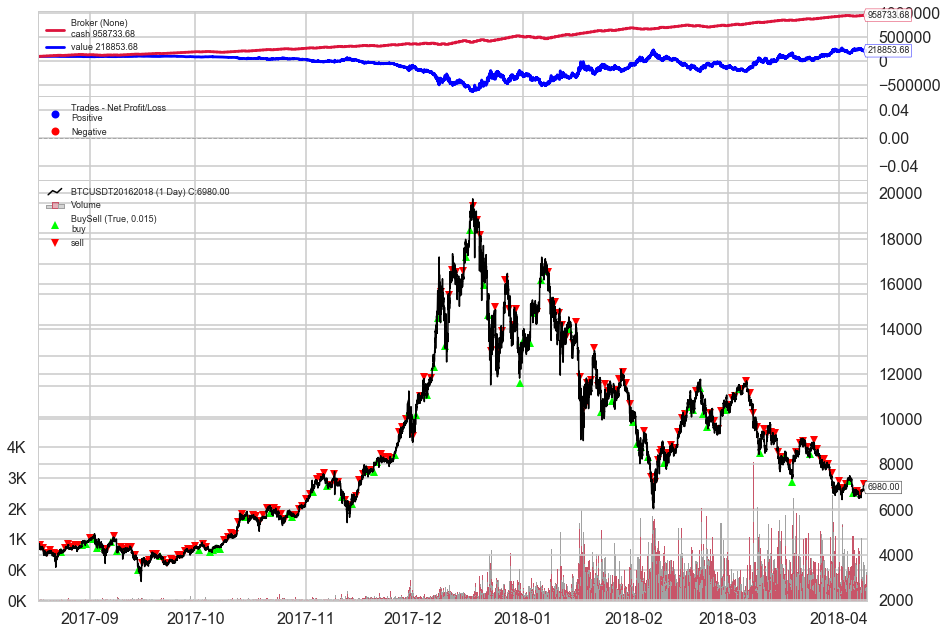

[[<matplotlib.figure.Figure at 0x11c858278>]]

In [31]:
cerebro.plot()